# Preamble

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%matplotlib inline

In [3]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

import numpy as np
import pickle

from multiprocessing import Pool 
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm as tqdm


import integrals as integ
import diff_eq_multi_2 as diff_eq
import physics as phys

# Load the standard solution.
a = pickle.load(open('../data/std_soln_He.p','rb'))

std_Tm = interp1d(a[0,:], a[1,:])
std_xH = interp1d(a[0,:], a[2,:])

# Constraints on $Q_\text{eff}$

In [4]:
def max_Q_d_eff(m_m, m_C, f, Q):
    '''
    Constraints on Q_eff from self-interaction, CMB and tight coupling. Q_eff 
    is defined by Q_eff^4 = alpha_C*alpha_m / alpha_EM^2
    '''
    g_em    = np.sqrt(4*np.pi*phys.alpha)
    mu_pC   = m_C*phys.mp/(m_C + phys.mp)
    f_ratio = 1. + phys.omega_baryon/(f*phys.omega_DM)
    
    max_SI             = 0.26*(m_C/1e9)**(3/8) * np.sqrt(np.sqrt(4*np.pi)/g_em)
    max_CMB            = 1e-3 * np.sqrt(m_C/1e9) * np.sqrt(m_m/1e9) * (1e9/(m_m + m_C))**0.25 * f_ratio**0.25
    max_tight_coupling = 0.08 * np.sqrt(Q) * np.sqrt(m_C/1e8) * (1e9/m_m)**0.25
    
    return np.min((max_SI, max_CMB, max_tight_coupling))

# Function for Solving ODE

In [5]:
 def solve_ODE(params):
    '''
    Sets up the ODE with parameters given in params. 
    '''
        
    _m_m      = params[0]
    _m_C      = params[1]
    _f        = params[2]
    _Q        = params[3]
    _rtol     = params[4]
    _max_step = params[5]
    init_cond = params[6]
    
    # Fine the maximum Q_d,eff from the input parameters. 
    _Q_d_eff = max_Q_d_eff(_m_m, _m_C, _f, _Q)

    def to_integrate(rs, var):

        # Decide whether to include neutrals.
        neutral_H  = True
        neutral_He = True

        # Gets the function that returns all the derivatives. 
        # Last option here is whether to integrate with log_T_C or not.
        return diff_eq.DM_baryon_ODE(
            rs, var,
            _m_m, _m_C, _Q, _Q_d_eff, neutral_H, neutral_He, _f, True
        )

    # Number of attempts before giving up. 
    N_attempts = 0
    # Flag to determine if solution was reached.
    solved     = False

    # List of indices (m_m, Q) where the solution failed. 
    error_arr = [] 

    while (not solved) and (N_attempts < 1):
        # Keep attempting until solved or we've tried twice. 

        try:

            N_attempts += 1

            # Solve using solve_ivp. 
            soln = solve_ivp(
                to_integrate, [rs_vec[0], rs_vec[-1]], init_cond, 
                method='BDF', t_eval=rs_vec, 
                rtol=_rtol, max_step=_max_step
            )

        except:
            # solve_ivp returned an error. Adjust the tolerance
            # and step size and try again. 

            _rtol /= 1.2
            _max_step /= 1.5

        else:
            # solve_ivp completed successfully. However, we still need to check
            # that the solution managed to integrate over the entire redshift range,
            # and that there are no NaNs in the solution.
            if soln['t'].size == rs_vec.size and not np.isnan(soln['y']).any():

                solved = True

    if not solved:
        # If solution fails, simply return False. 
        soln = False

    return soln 

# Fixed Parameters

In [6]:
rs_start = 4000
rs_vec   = np.flipud(np.arange(10., rs_start, 1))

# Fixed Parameters
f   = 1e-4
m_C = 1e8   

# Loop Points
# m_m_arr = np.array([3e6, 1e7, 3e7, 1e8, 3e8, 1e9, 3e9, 1e10, 3e10, 1e11, 3e11, 1e12, 3e12, 1e13])
m_m       = 3e9
Q_arr     = 10**np.arange(-6., 0.2, 0.2) # 31 entries
# Q_arr     = np.concatenate((
#     10**np.arange(-6.,  -4., 0.2), 
#     10**np.arange(-4.,  -2., 0.04),
#     10**np.arange(-2.,  0.2, 0.2)
# ), axis=None)
V_rel_arr = np.arange(0., 4.1, 0.103) * 29e5 / phys.c
V_rel_arr[0] = 1e-16
# Q_arr = Q_arr[::3]
# V_rel_arr = V_rel_arr[::10]

In [7]:
print(Q_arr)

[1.00000000e-06 1.58489319e-06 2.51188643e-06 3.98107171e-06
 6.30957344e-06 1.00000000e-05 1.58489319e-05 2.51188643e-05
 3.98107171e-05 6.30957344e-05 1.00000000e-04 1.58489319e-04
 2.51188643e-04 3.98107171e-04 6.30957344e-04 1.00000000e-03
 1.58489319e-03 2.51188643e-03 3.98107171e-03 6.30957344e-03
 1.00000000e-02 1.58489319e-02 2.51188643e-02 3.98107171e-02
 6.30957344e-02 1.00000000e-01 1.58489319e-01 2.51188643e-01
 3.98107171e-01 6.30957344e-01 1.00000000e+00]


# Loop

In [ ]:
import warnings
warnings.simplefilter('ignore')

soln_arr = np.zeros((Q_arr.size, V_rel_arr.size, rs_vec.size, 6))

error_arr = []

for i,Q in enumerate(tqdm(Q_arr)):
    
     # Initial conditions are T_CMB - T_b, T_b - T_m, log(T_C), log(V_bm), log(V_cb), xe
#     init_cond = [1e-5, 1e-5, np.log(1e-6), np.log(1e-16), np.log(1e-16), 1.] 
    init_cond = np.array([[1e-5, 1e-5, np.log(1e-6), np.log(1e-16), np.log(V_rel), 1.] for V_rel in V_rel_arr])
    
    # List of parameters that need to be passed. 
    params = zip(
        m_m*np.ones_like(V_rel_arr) , m_C*np.ones_like(V_rel_arr),
        f*np.ones_like(V_rel_arr)   , Q*np.ones_like(V_rel_arr),
        1e-5*np.ones_like(V_rel_arr), np.inf*np.ones_like(V_rel_arr),
        init_cond
    )
    
    
    # Parallelization.
    pool = Pool(V_rel_arr.size)
    
    soln_raw_arr = list(tqdm(pool.imap(solve_ODE, params)))
    
    for j,soln_raw in enumerate(soln_raw_arr): 
    
        if soln_raw:

            soln = np.transpose(soln_raw['y'])
            
            soln_arr[i,j] = soln

            # Convert to (T_b, T_m, T_C, V_bm, V_mC)
            soln_arr[i,j,:,0] = phys.TCMB(rs_vec) - soln_arr[i,j,:,0]
            soln_arr[i,j,:,1] = soln_arr[i,j,:,0] - soln_arr[i,j,:,1]
            soln_arr[i,j,:,2] = np.exp(soln_arr[i,j,:,2])
            soln_arr[i,j,:,3] = np.exp(soln_arr[i,j,:,3])
            soln_arr[i,j,:,4] = np.exp(soln_arr[i,j,:,4])

        else:
        
            # False was returned, and the solution failed. Append the index
            # to error_arr.
            error_arr.append([i,j])
            
    print('Errors: ', error_arr)
        


In [8]:
pickle.dump((soln_arr, error_arr), open('/tigress/hongwanl/millicharged_DM_with_bath/Vrel_scan_fixed_He_bug/data_Vrel_m_m_3_GeV_m_C_100_MeV.p','wb'))

soln_arr, error_arr = pickle.load(open('/tigress/hongwanl/millicharged_DM_with_bath/Vrel_scan_fixed_He_bug/data_Vrel_m_m_3_GeV_m_C_100_MeV.p','rb'))

# error_arr = to_clean


# Handling Problematic Points

In [13]:
import warnings
warnings.simplefilter('ignore')

# while len(error_arr) > 0:

Nrun = 0

while Nrun < 30 and len(error_arr) > 0:
    
    Nrun += 1

    print('Number of problematic points: ', len(error_arr))

    # Pull the list of Q and V_rel that need to be iterated over from error_arr.
    # Can change the first entry of V_rel from 1e-16 to 1e-13 if difficult to solve. 
    Q_err_arr     = np.array([Q_arr[pt[0]] for pt in error_arr])
    V_rel_err_arr = np.array([V_rel_arr[pt[1]] for pt in error_arr])
    
    print(Q_err_arr, V_rel_err_arr)


    # Keeps track of which points become solved after running this cell.
    solved_arr  = [False for _ in error_arr]

    # Strategies: adjust step-size, initial conditions

    # New set of parameters for solution, pulled from the indices of error_arr. 
    # Added helper indices in front to be accessed later.
    params_full = np.transpose([
        np.arange(len(error_arr)),
        [err_ind[0] for err_ind in error_arr],
        [err_ind[1] for err_ind in error_arr],
        m_m*np.ones_like(Q_err_arr)   , m_C*np.ones_like(Q_err_arr),
        f*np.ones_like(Q_err_arr)     , Q_err_arr,
        8e-3*np.ones_like(Q_err_arr)  , np.inf*np.ones_like(Q_err_arr),
        V_rel_err_arr
    ])

    # Split the parameters into chunks that can be fed into each thread. 
    # There are V_rel_arr.size threads.
    param_chunks = np.array_split(params_full, V_rel_err_arr.size//V_rel_arr.size + 1)

    for params in tqdm(param_chunks):

        # Parallelization.
        pool = Pool(Q_arr.size)

        # Initial conditions are T_CMB - T_b, T_b - T_m, log(T_C), log(V_bm), log(V_cb), xe
        # init_cond = [2e-2, 2e-2, np.log(3e-4), np.log(1e-16), np.log(1e-16), 1.] 
        
        # Try small steps at the last few stubborn points. Start with -4 for step size. 
        
#         T_diff_init = 10.**(-2.*np.random.random() - 2.)
#         step_size   = 10.**(-1.*np.random.random() - 4.)
#         T_C_init    = 10.**(-2.*np.random.random() - 3.)

        T_diff_init = 10.**(-2.*np.random.random() - 2.)
        step_size   = 10.**(-1.*np.random.random() - 4.)
        T_C_init    = 10.**(-2.*np.random.random() - 3.)
        
#         T_diff_init = 2.4e-4
#         step_size = 4.13e-6
#         T_C_init = 3e-6
#         max_step = np.inf
        max_step = np.inf
        
        
        init_cond_arr = np.array([[T_diff_init, T_diff_init, np.log(T_C_init), np.log(1e-16), np.log(V_rel), 1.] for V_rel in params[:,-1]])
        
        print('T Diff param: ', T_diff_init)
        print('T_C param: ', T_C_init)
        print('Step size param: ', step_size)
        print('Max step param: ', max_step)
        print('Nrun: ', Nrun)
        
        params_diff_eq = zip(
            m_m*np.ones_like(params[:,-1]) , m_C*np.ones_like(params[:,-1]),
            f*np.ones_like(params[:,-1])   , params[:,6],
            step_size*np.ones_like(params[:,-1]), max_step*np.ones_like(params[:,-1]),
            init_cond_arr
        )

        soln_raw_arr = list(tqdm(pool.imap(solve_ODE, params_diff_eq)))

        for err_ind,i,j,soln_raw in zip(
            params[:,0].astype(int), 
            params[:,1].astype(int), params[:,2].astype(int), soln_raw_arr
        ): 

            if soln_raw:
                # Solution was achieved.

                soln = np.transpose(soln_raw['y'])

                soln_arr[i,j] = soln

                # Convert to (T_b, T_m, T_C, V_bm, V_mC)
                soln_arr[i,j,:,0] = phys.TCMB(rs_vec) - soln_arr[i,j,:,0]
                soln_arr[i,j,:,1] = soln_arr[i,j,:,0] - soln_arr[i,j,:,1]
                soln_arr[i,j,:,2] = np.exp(soln_arr[i,j,:,2])
                soln_arr[i,j,:,3] = np.exp(soln_arr[i,j,:,3])
                soln_arr[i,j,:,4] = np.exp(soln_arr[i,j,:,4])

                print('Solved: [', i, ', ', j, ']')

                # Set the solved_arr at the appropriate index to True.
                solved_arr[err_ind] = True

    # Produce a new error_arr, with entries in solved_arr that are True removed.
    error_arr = [ind for solved,ind in zip(solved_arr,error_arr) if not solved]

    print(error_arr)

    pickle.dump((soln_arr, error_arr), open('/tigress/hongwanl/millicharged_DM_with_bath/Vrel_scan_fixed_He_bug/data_Vrel_m_m_3_GeV_m_C_100_MeV.p','wb'))

# REPEAT THIS CELL AS MANY TIMES AS NECESSARY TO REMOVE ALL PROBLEMATIC POINTS.

Number of problematic points:  2
[2.51188643e-06 6.30957344e-06] [1.e-13 1.e-13]


T Diff param:  0.005752512696922563
T_C param:  1.9315479317881495e-05
Step size param:  7.248889691719876e-05
Max step param:  inf
Nrun:  1




[[2, 0], [4, 0]]
Number of problematic points:  2
[2.51188643e-06 6.30957344e-06] [1.e-13 1.e-13]


T Diff param:  0.00012778641515817882
T_C param:  0.0008798968187729575
Step size param:  2.6170730879191016e-05
Max step param:  inf
Nrun:  2




[[2, 0], [4, 0]]
Number of problematic points:  2
[2.51188643e-06 6.30957344e-06] [1.e-13 1.e-13]


T Diff param:  0.0007905957146978452
T_C param:  0.0001345865182915479
Step size param:  4.1675853026469756e-05
Max step param:  inf
Nrun:  3



Solved: [ 4 ,  0 ]

[[2, 0]]
Number of problematic points:  1
[2.51188643e-06] [1.e-13]


T Diff param:  0.00035497066656223523
T_C param:  0.00023777870836495408
Step size param:  3.9388559138425965e-05
Max step param:  inf
Nrun:  4




[[2, 0]]
Number of problematic points:  1
[2.51188643e-06] [1.e-13]


T Diff param:  0.0032894724891153328
T_C param:  0.0005454875973597362
Step size param:  3.981278893915487e-05
Max step param:  inf
Nrun:  5




[[2, 0]]
Number of problematic points:  1
[2.51188643e-06] [1.e-13]


T Diff param:  0.001585647272596657
T_C param:  0.0003263880743667953
Step size param:  1.1892504397466703e-05
Max step param:  inf
Nrun:  6



Solved: [ 2 ,  0 ]

[]


### Make a Plot

Text(0, 0.5, 'Millicharge $Q$')

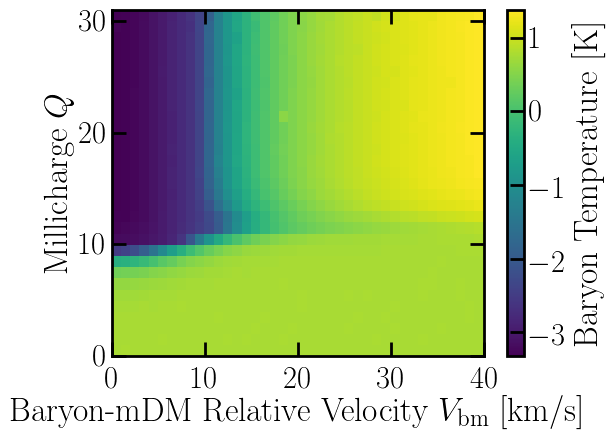

In [12]:
soln_arr, error_arr = pickle.load(open('/tigress/hongwanl/millicharged_DM_with_bath/Vrel_scan_fixed_He_bug/data_Vrel_m_m_30_MeV_m_C_100_MeV.p','rb'))

# rs_vec[-9] is 1+z = 18. 

plt.figure(figsize=(6,4.5))

# plt.yscale('log')

# plt.contourf(V_rel_arr * phys.c / 1e5, Q_arr,  soln_arr[:,:,-9,0] / phys.kB)
plt.pcolormesh(np.log(soln_arr_2[:,:,-1,0] / phys.kB))

plt.colorbar(label='Baryon Temperature [K]')

plt.axis([0, 40, 0, 31])

plt.xlabel(r'Baryon-mDM Relative Velocity $V_\mathrm{bm}$ [km/s]')
plt.ylabel(r'Millicharge $Q$')

Text(0, 0.5, 'Millicharge $Q$')

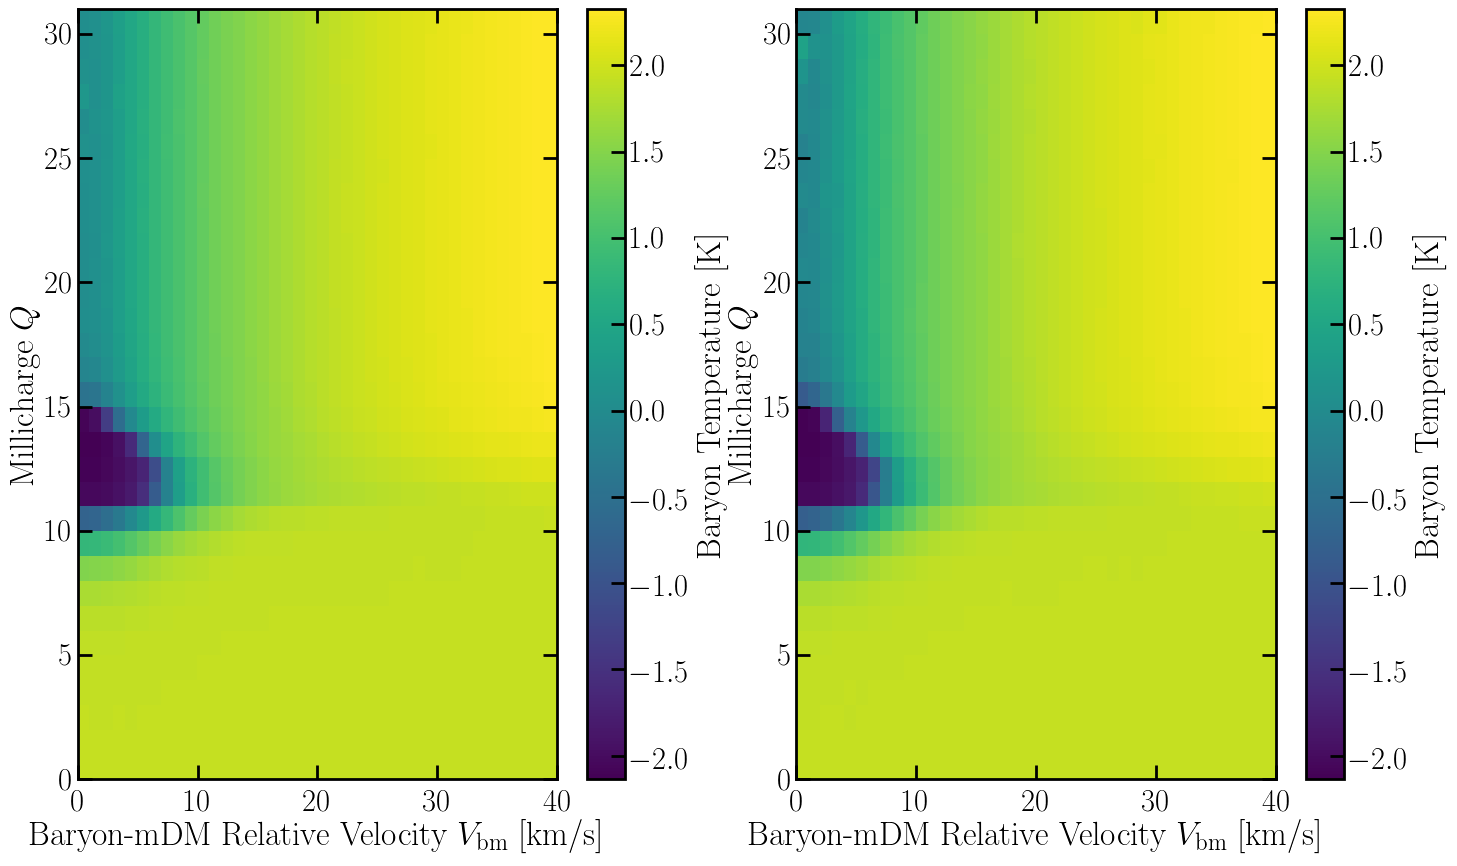

In [72]:
soln_arr, error_arr = pickle.load(open('/tigress/hongwanl/millicharged_DM_with_bath/Vrel_scan_fixed_He_bug/data_Vrel_m_m_30_MeV_m_C_100_MeV.p','rb'))
soln_arr_2, error_arr_2 = pickle.load(open('/tigress/hongwanl/millicharged_DM_with_bath/Vrel_scan/data_Vrel_m_m_3e7.p','rb'))

# rs_vec[-9] is 1+z = 18. 

f, axs = plt.subplots(1, 2, figsize=(17,10))

# plt.yscale('log')

# plt.contourf(V_rel_arr * phys.c / 1e5, Q_arr,  soln_arr[:,:,-9,0] / phys.kB)

ax = axs[0]

mappab = ax.pcolormesh(np.log(soln_arr[:,:,-9,0] / phys.kB))
#     ax.pcolormesh(np.log(soln_arr_2[:,:,-9,0] / phys.kB))

dat = np.log(soln_arr[:,:,-9,0] / phys.kB)


mappab.set_clim((np.min(dat), np.max(dat)))

cbar = plt.colorbar(mappab, ax=ax, label='Baryon Temperature [K]')

ax.set_xlim((0, 40))
ax.set_ylim((0, 31))

ax.set_xlabel(r'Baryon-mDM Relative Velocity $V_\mathrm{bm}$ [km/s]')
ax.set_ylabel(r'Millicharge $Q$')


ax = axs[1]

mappab = ax.pcolormesh(np.log(soln_arr_2[:,:,-9,0] / phys.kB))
mappab.set_clim((np.min(dat), np.max(dat)))
cbar = plt.colorbar(mappab, ax=ax, label='Baryon Temperature [K]')

ax.set_xlim((0, 40))
ax.set_ylim((0, 31))

ax.set_xlabel(r'Baryon-mDM Relative Velocity $V_\mathrm{bm}$ [km/s]')
ax.set_ylabel(r'Millicharge $Q$')


In [78]:

print(np.min(np.array([soln_arr[:, :, -9, 0]/soln_arr_2[:, :, -9, 0]])))
print(np.max(np.array([soln_arr[:, :, -9, 0]/soln_arr_2[:, :, -9, 0]])))

0.6916254953355838
1.56721739770019


In [ ]:
def generate_errors(i_start, i_end, j_start, j_end):
    err_ary = []
    for i in np.arange(i_start, i_end+1):
        for j in np.arange(j_start, j_end+1):
            err_ary.append([i,j])
            
    return err_ary

# Q first. 
to_clean = generate_errors(30, 30, 0, 5)
            

In [ ]:
soln_arr[13,0,:,0]

In [ ]:
10**0.2

In [ ]:
V_rel_arr